In [1]:
from libraries import MyDAQ
from libraries import functions as H
import matplotlib.pyplot as plt
import numpy as np
import nidaqmx as dx
from scipy.signal import sawtooth, square
import libraries
from libraries import PMConverter
from scipy.fft import rfft, rfftfreq, irfft
import time
all_list = [H.RC_C]

daq = MyDAQ()
daq.name = 'MyDAQ1'
daq.samplerate = 200000
read_channel = 'AI0'	
write_channel = 'AO0'

In [2]:
PM = PMConverter()
daq = MyDAQ()

In [3]:
daq.name = 'MyDAQ1'
daq.samplerate = int(2e5)
read_channel = 'AI0'	
write_channel = 'AO0'
carrierFrequency = 2e4
sps = 20000
amplitude = 2

text = "Hi!"
binary = PM.text_to_binary(text)
fm_signal = PM.binary_to_pm(binary, fmType=1)

voltages = PM.pm_to_voltage_array(fm_signal, sps, f=carrierFrequency, fs=daq.samplerate, A=amplitude)


In [4]:
print(len(voltages))
#data = daq.readwrite(voltages, read_channel, write_channel)
data = voltages
window = np.hanning(len(data))
windowed_data = data * window
fft = np.fft.rfft(windowed_data)
freqs = np.fft.rfftfreq(len(data), 1 / daq.samplerate)
amplitude = np.abs(fft)

# Plot
#plt.figure(figsize=(10, 6))
#plt.scatter(freqs, amplitude, s=10, color='darkblue', alpha=0.7, label='FFT Amplitude')
#plt.axvline(carrierFrequency)
#lt.xscale('log')
#plt.yscale('log')  # Optional: helps when amplitudes span multiple orders
#plt.xlabel('Frequency (Hz)')
#plt.ylabel('Amplitude')
#plt.title('Frequency Spectrum (FFT)')
#plt.grid(True, which='both', linestyle='--', linewidth=0.5)
##plt.legend()
#plt.tight_layout()
#plt.show()

_, amplitudes, phases = PM.retrieve_phases(data, daq.samplerate, sps, carrierFrequency)

print(len(phases), len(fm_signal))

binary_back = PM.pm_to_binary(phases, fmType=1)
print("Recovered Binary:", binary_back)

text_back = PM.binary_to_text(binary_back)
print("Recovered Text:", text_back)

480000
24
-6.968156398186783e-07 1.3430043227883697e-05
-6.968156398186783e-07 1.3430043227883697e-05
-6.968156398186783e-07 1.3430043227883697e-05
-6.968156398186783e-07 1.3430043227883697e-05
-6.968156398186783e-07 1.3430043227883697e-05
-6.968156398186783e-07 1.3430043227883697e-05
-6.968156398186783e-07 1.3430043227883697e-05
-6.968156398186783e-07 1.3430043227883697e-05
-6.968156398186783e-07 1.3430043227883697e-05
-6.968156398186783e-07 1.3430043227883697e-05
-6.968156398186783e-07 1.3430043227883697e-05
-6.968156398186783e-07 1.3430043227883697e-05
-6.968156398186783e-07 1.3430043227883697e-05
-6.968156398186783e-07 1.3430043227883697e-05
-6.968156398186783e-07 1.3430043227883697e-05
-6.968156398186783e-07 1.3430043227883697e-05
-6.968156398186783e-07 1.3430043227883697e-05
-6.968156398186783e-07 1.3430043227883697e-05
-6.968156398186783e-07 1.3430043227883697e-05
-6.968156398186783e-07 1.3430043227883697e-05
-6.968156398186783e-07 1.3430043227883697e-05
-6.968156398186783e-07 1

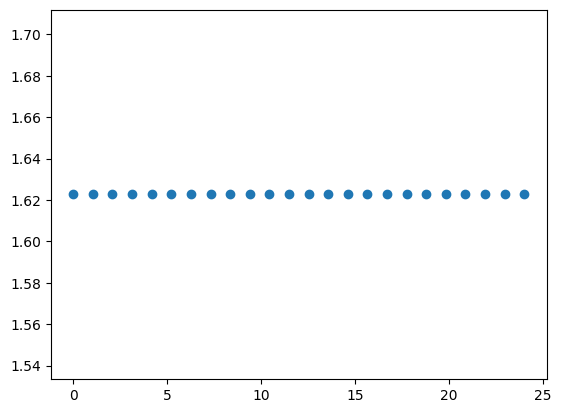

In [5]:
plt.scatter(np.linspace(0, len(phases), len(phases)), phases)
plt.show()

(48000,)
writeTask.start took 0.026923 seconds.
42616 42616 48000


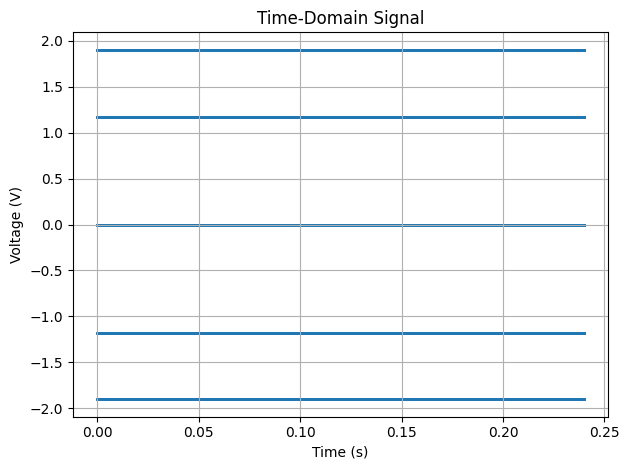

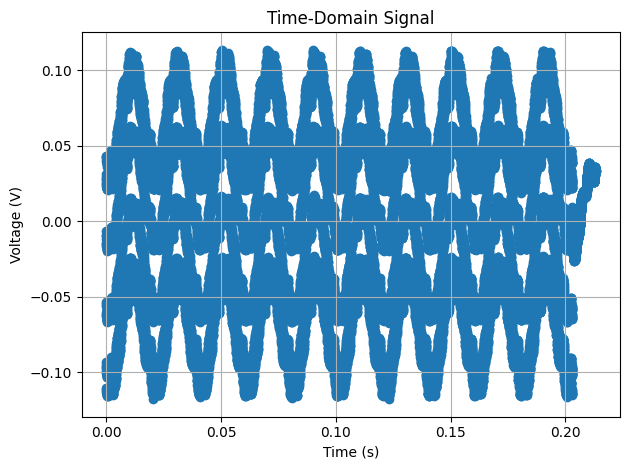

In [6]:
tArray = np.linspace(0, len(voltages) / daq.samplerate, len(voltages), endpoint=False)
print(voltages.shape)
data = daq.readwrite(voltages, read_channel, write_channel)
tArrayd = np.linspace(0, len(data) / daq.samplerate, len(data), endpoint=False)

print(len(tArrayd), len(data), len(voltages))

plt.scatter(tArray, voltages, s=1)  # s=1 to avoid huge dots
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Time-Domain Signal')
plt.grid(True)
plt.tight_layout()
plt.show()
plt.scatter(tArrayd, data)
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Time-Domain Signal')
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
duration = 5
amplitude = 2
freq = 20000
phase = 0
_, signal = daq.generateWaveform('sine', daq.samplerate, freq, amplitude, phase, duration)
signal = []
for i in range(0, 6):
    for j in range(0, 20000):
        signal.append((i - 3))
data = daq.readwrite(np.array(signal), read_channel, write_channel)
plt.scatter(np.arange(len(signal)), signal, label='sig')
plt.scatter(np.arange(len(data)), data, label='data')
plt.legend()
plt.show()

print(len(signal) - len(data))
countt = 0
for i in range(0, 6):
    count = np.sum(np.abs(data - (i-3)) <= 0.1)
    countt += count
    print(f"{count} data points are within 0.1 V of 6 V.")
print(countt)
print(len(data))